In [1]:
'''
# For GPU support, install the following packages:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install gymnasium[box2d]
!pip install stable-baselines3[extra]
'''

'\n# For GPU support, install the following packages:\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128\n!pip install gymnasium[box2d]\n!pip install stable-baselines3[extra]\n'

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import gymnasium as gym
import itertools
import time

# Import Frame Stacker Wrapper and Grayscale Wrapper
from gymnasium.wrappers import GrayscaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import matplotlib
import matplotlib.pyplot as plt

In [3]:
# check if GPU is available
torch.cuda.is_available()

True

# Using an image as a state

In [36]:
class ImageObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        sample_img = env.render()
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=sample_img.shape,
            dtype=sample_img.dtype
        )

    def observation(self, obs):
        # Return the rendered image as the observation
        return self.env.render()

# Create the LunarLanderContinuous environment
env = gym.make("LunarLanderContinuous-v3", render_mode="rgb_array")

# Reset the environment to get the first state
state, _ = env.reset()

env = ImageObservationWrapper(env)
state, _ = env.reset()

print(state.shape)  # Should be (height, width, 3)

(400, 600, 3)


# Converting the image to grayscale and stacking frames

In [37]:
# Grayscale
env = GrayscaleObservation(env, keep_dim=True)  # Convert to grayscale
# Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, n_stack=4, channels_order='last')  # Stack 4 frames

state = env.reset()

state.shape

(1, 400, 600, 4)

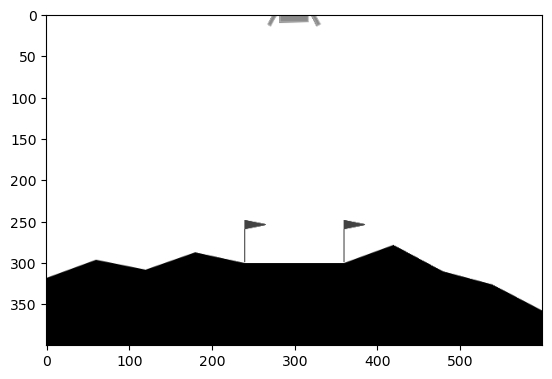

In [38]:
plt.imshow(state[0])

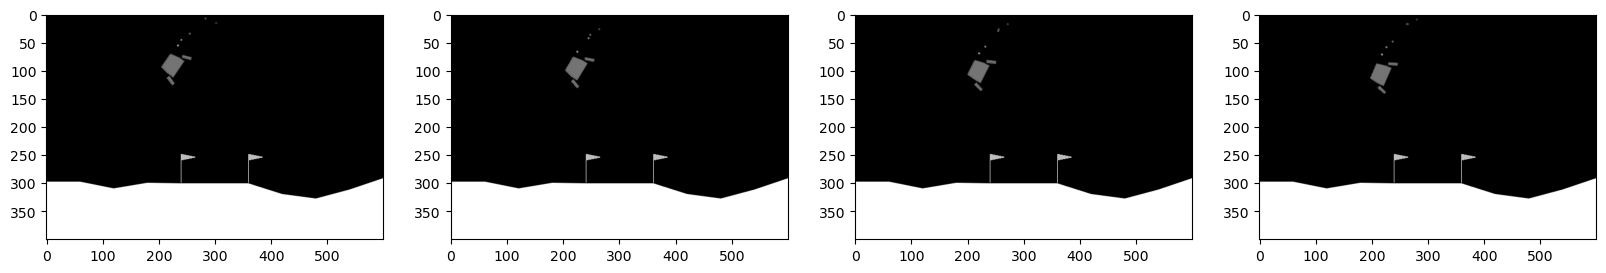

In [39]:
state = env.reset()

action = np.array([-1, -1])  # Example action for LunarLanderContinuous

for i in range(30):
    state, reward, done, info = env.step([action])

# Visualize stacked frames
plt.figure(figsize=(20, 16))
for idx in range(state.shape[3]):

    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[0, :, :, idx], cmap="gray")
plt.show()

> stacked images

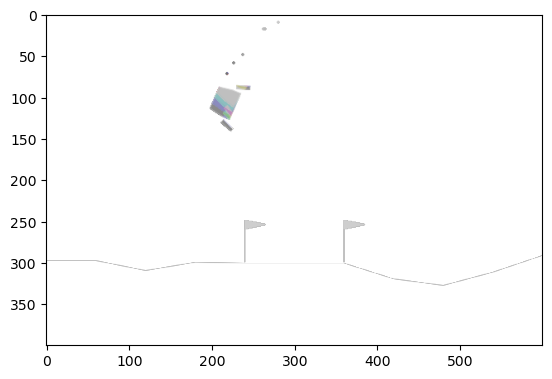

In [40]:
plt.imshow(state[0])

In [41]:
state = env.reset()

# Train the RL agent using PPO

In [42]:
import os
# Import PPO
from stable_baselines3 import PPO
# Import the callback for saving the model
from stable_baselines3.common.callbacks import BaseCallback

In [43]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "PPO_model_{}.pth".format(self.n_calls))
            self.model.save(model_path)
        return True

In [44]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [45]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR, verbose=1)

In [46]:
agent = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=3e-4, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [47]:
# Train the agent
agent.learn(total_timesteps=100, callback=callback)

Logging to ./logs/PPO_1
----------------------------
| time/              |     |
|    fps             | 33  |
|    iterations      | 1   |
|    time_elapsed    | 15  |
|    total_timesteps | 512 |
----------------------------


# Test

In [ ]:
agent = PPO.load(os.path.join(CHECKPOINT_DIR, "PPO_model_10000.pth"), env=env)